## Notebook that pulls together known subject and sample covariates cleans up as neccessary and writes to single file 

In [1]:
!date

Wed Apr 28 02:27:42 UTC 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [3]:
# parameter variables
cohort = 'amppd'

# directories 
wrk_dir = f'/home/jupyter/{cohort}'
info_dir = f'{wrk_dir}/sample_info'

# input files
subject_info_file = f'{info_dir}/amppd_demographicsPlus_2019_v1release_1015.csv'
cell_fracs_file = f'{info_dir}/amppd.wb.pred_cell_fracs.csv'
assay_metrics_file = f'{info_dir}/rna_quality_metrics.csv'

# output files
assay_covs_files = f'{info_dir}/{cohort}_rna_sample_info.csv'

# constants
max_cov_missing_rate = 0.5
repeated_id_dict = {'PPMI3966B1': 'PPMI3966', 'PPMI3966B2': 'PPMI3966', 
                    'PPMI3966B3': 'PPMI3966', 'PPMI3966B5': 'PPMI3966'}

#### load subject info file, from AMP-PD, and merge with cell info

In [4]:
subj_info = pd.read_csv(subject_info_file)
subj_info['wgsid'] = subj_info['participant_id']
print(subj_info.shape)
display(subj_info.head())

(4298, 17)


,participant_id,GUID,visit_name,visit_month,age_at_baseline,sex,ethnicity,race,education_level_years,diagnosis_at_baseline,diagnosis_latest,case_control_other_at_baseline,case_control_other_latest,study_arm,prodromal_category,Recruitment,wgsid
0,PP-41564,NaN,SC,-1.0,22,Male,Hispanic or Latino,White,Greater than 16 years,No PD Nor Other Neurological Disorder,No PD Nor Other Neurological Disorder,Control,Control,Genetic Registry Unaffected,Unknown/Not collected as enrollment criterion,HC_GR,PP-41564
1,PD-PDZV843ATF,PDZV843ATF,M0,0.0,24,Male,Not Hispanic or Latino,White,12-16 years,No PD Nor Other Neurological Disorder,No PD Nor Other Neurological Disorder,Control,Control,Healthy Control,Unknown/Not collected as enrollment criterion,HC,PD-PDZV843ATF
2,PD-PDCK871NBR,PDCK871NBR,M0,0.0,24,Male,Not Hispanic or Latino,White,12-16 years,No PD Nor Other Neurological Disorder,No PD Nor Other Neurological Disorder,Control,Control,Healthy Control,Unknown/Not collected as enrollment criterion,HC,PD-PDCK871NBR
3,PP-51718,NaN,SC,-1.0,25,Male,Not Hispanic or Latino,White,12-16 years,No PD Nor Other Neurological Disorder,No PD Nor Other Neurological Disorder,Control,Control,Genetic Registry Unaffected,Unknown/Not collected as enrollment criterion,HC_GR,PP-51718
4,PP-56267,NaN,SC,-1.0,25,Male,Not Hispanic or Latino,White,12-16 years,Other Neurological Disorder(s),Other Neurological Disorder(s),Other,Other,Genetic Registry Unaffected,Unknown/Not collected as enrollment criterion,NaN,PP-56267


#### load the sample assays metrics info

In [5]:
# load the sample QC info
metrics_info = pd.read_csv(assay_metrics_file, index_col=0)
print(metrics_info.shape)
display(metrics_info.head())

(8356, 13)


,Specimen_Quantity,Concentration,Submitted_Volume__ul_,Normalization_Volume__30ng_ul_,Total_Volume__ul_,Input_RNASeq__ng_,Input_miRNA__ng_,_260_230_Ratio,_260_280_Ratio,RIN_Value,Box,Plate,Position
sample_id,,,,,,,,,,,,,
PP-3174-SVM36T1,1.0,115.90,8.628128,29.371872,38.0,684.210526,276.315789,1.98,2.10,8.4,J_RNA_1,P101,1
PP-3201-BLM0T1,1.0,80.07,12.489072,25.510928,38.0,684.210526,276.315789,1.45,2.13,8.4,J_RNA_1,P101,2
PP-3057-SVM24T1,1.0,219.70,4.551661,33.448339,38.0,684.210526,276.315789,2.66,2.13,6.9,J_RNA_1,P101,3
PP-4126-SVM12T1,1.0,100.06,9.994004,28.005996,38.0,684.210526,276.315789,0.73,2.16,7.5,J_RNA_1,P101,4
PP-4117-BLM0T1,1.0,124.40,8.038585,29.961415,38.0,684.210526,276.315789,1.72,2.08,7.4,J_RNA_1,P101,5


#### split sample name index into constituent bits

In [6]:
col_names = ['cohort', 'idpart', 'visit']
id_parts = metrics_info.index.str.split('-', expand=True).to_frame(index=False, name=col_names)
id_parts['sample_id'] = metrics_info.index
id_parts['wgsid'] = id_parts['cohort'] + '-' + id_parts['idpart']
print(id_parts.shape)
display(id_parts.sample(5))
# fix sampleid for repeated sample 
# id_parts['sampleid'].replace(repeated_id_dict, inplace=True)

(8356, 5)


,cohort,idpart,visit,sample_id,wgsid
2828,PP,3580,SVM24T1,PP-3580-SVM24T1,PP-3580
7258,PD,PDJK502DEH,BLM0T1,PD-PDJK502DEH-BLM0T1,PD-PDJK502DEH
137,PP,3169,SVM36T1,PP-3169-SVM36T1,PP-3169
2064,PP,3778,SVM24T1,PP-3778-SVM24T1,PP-3778
887,PP,54373,BLM0T1,PP-54373-BLM0T1,PP-54373


#### get counts by day

In [7]:
id_parts['visit'].value_counts()

BLM0T1      2939
SVM12T1     1471
SVM6T1      1414
SVM24T1     1290
SVM36T1      541
SVM18T1      493
SVM0_5T1     208
Name: visit, dtype: int64

#### merge the split assay IDs bits onto the other info

In [8]:
info_df = id_parts.merge(subj_info, how='left', on='wgsid')
info_df.drop_duplicates(subset=['sample_id'], inplace=True)
info_df.set_index('sample_id', drop=True, inplace=True)
print(info_df.shape)
display(info_df.head())

(8356, 20)


,cohort,idpart,visit,wgsid,participant_id,GUID,visit_name,visit_month,age_at_baseline,sex,ethnicity,race,education_level_years,diagnosis_at_baseline,diagnosis_latest,case_control_other_at_baseline,case_control_other_latest,study_arm,prodromal_category,Recruitment
sample_id,,,,,,,,,,,,,,,,,,,,
PP-3174-SVM36T1,PP,3174,SVM36T1,PP-3174,PP-3174,NaN,SC,-1.0,51,Male,Not Hispanic or Latino,White,Greater than 16 years,Idiopathic PD,Idiopathic PD,Case,Case,PD,Unknown/Not collected as enrollment criterion,PD
PP-3201-BLM0T1,PP,3201,BLM0T1,PP-3201,PP-3201,NaN,SC,-1.0,64,Female,Not Hispanic or Latino,White,Greater than 16 years,No PD Nor Other Neurological Disorder,No PD Nor Other Neurological Disorder,Control,Control,Healthy Control,Unknown/Not collected as enrollment criterion,HC
PP-3057-SVM24T1,PP,3057,SVM24T1,PP-3057,PP-3057,NaN,SC,-1.0,60,Female,Not Hispanic or Latino,White,Greater than 16 years,No PD Nor Other Neurological Disorder,No PD Nor Other Neurological Disorder,Control,Control,Healthy Control,Unknown/Not collected as enrollment criterion,HC
PP-4126-SVM12T1,PP,4126,SVM12T1,PP-4126,PP-4126,NaN,SC,-1.0,56,Male,Not Hispanic or Latino,White,12-16 years,Idiopathic PD,Idiopathic PD,Case,Case,PD,Unknown/Not collected as enrollment criterion,PD
PP-4117-BLM0T1,PP,4117,BLM0T1,PP-4117,PP-4117,NaN,SC,-1.0,60,Female,Not Hispanic or Latino,White,12-16 years,Idiopathic PD,Idiopathic PD,Case,Case,PD,Unknown/Not collected as enrollment criterion,PD


#### now merge the assay QC/metrics with rest of info by assay's sample id

In [9]:
info_df = info_df.merge(metrics_info, how='left', left_index=True, right_index=True)
print(info_df.shape)
display(info_df.head())

(8356, 33)


,cohort,idpart,visit,wgsid,participant_id,GUID,visit_name,visit_month,age_at_baseline,sex,...,Normalization_Volume__30ng_ul_,Total_Volume__ul_,Input_RNASeq__ng_,Input_miRNA__ng_,_260_230_Ratio,_260_280_Ratio,RIN_Value,Box,Plate,Position
sample_id,,,,,,,,,,,,,,,,,,,,,
PP-3174-SVM36T1,PP,3174,SVM36T1,PP-3174,PP-3174,NaN,SC,-1.0,51,Male,...,29.371872,38.0,684.210526,276.315789,1.98,2.10,8.4,J_RNA_1,P101,1
PP-3201-BLM0T1,PP,3201,BLM0T1,PP-3201,PP-3201,NaN,SC,-1.0,64,Female,...,25.510928,38.0,684.210526,276.315789,1.45,2.13,8.4,J_RNA_1,P101,2
PP-3057-SVM24T1,PP,3057,SVM24T1,PP-3057,PP-3057,NaN,SC,-1.0,60,Female,...,33.448339,38.0,684.210526,276.315789,2.66,2.13,6.9,J_RNA_1,P101,3
PP-4126-SVM12T1,PP,4126,SVM12T1,PP-4126,PP-4126,NaN,SC,-1.0,56,Male,...,28.005996,38.0,684.210526,276.315789,0.73,2.16,7.5,J_RNA_1,P101,4
PP-4117-BLM0T1,PP,4117,BLM0T1,PP-4117,PP-4117,NaN,SC,-1.0,60,Female,...,29.961415,38.0,684.210526,276.315789,1.72,2.08,7.4,J_RNA_1,P101,5


#### load the cell fractions and merge with other info

In [10]:
cfracs_df = pd.read_csv(cell_fracs_file, index_col=0)
print(cfracs_df.shape)

info_df = info_df.merge(cfracs_df, how='left', left_index=True, right_index=True)
print(info_df.shape)
display(info_df.head())

(8356, 5)
(8356, 38)


,cohort,idpart,visit,wgsid,participant_id,GUID,visit_name,visit_month,age_at_baseline,sex,...,_260_280_Ratio,RIN_Value,Box,Plate,Position,predicted_Basophils,predicted_Eosinophils,predicted_Lymphocytes,predicted_Monocytes,predicted_Neutrophils
sample_id,,,,,,,,,,,,,,,,,,,,,
PP-3174-SVM36T1,PP,3174,SVM36T1,PP-3174,PP-3174,NaN,SC,-1.0,51,Male,...,2.10,8.4,J_RNA_1,P101,1,0.560380,2.162557,40.122864,7.104857,50.073425
PP-3201-BLM0T1,PP,3201,BLM0T1,PP-3201,PP-3201,NaN,SC,-1.0,64,Female,...,2.13,8.4,J_RNA_1,P101,2,0.578421,1.445616,28.534248,6.620922,62.778732
PP-3057-SVM24T1,PP,3057,SVM24T1,PP-3057,PP-3057,NaN,SC,-1.0,60,Female,...,2.13,6.9,J_RNA_1,P101,3,0.565090,2.523346,28.050821,5.227817,63.626167
PP-4126-SVM12T1,PP,4126,SVM12T1,PP-4126,PP-4126,NaN,SC,-1.0,56,Male,...,2.16,7.5,J_RNA_1,P101,4,0.494943,1.141698,21.396591,5.793729,70.670326
PP-4117-BLM0T1,PP,4117,BLM0T1,PP-4117,PP-4117,NaN,SC,-1.0,60,Female,...,2.08,7.4,J_RNA_1,P101,5,0.677945,1.671368,35.617207,5.167748,56.879417


#### check the dtypes and fix as neccessary

In [11]:
pd.set_option('display.max_rows', None)
# display(info_df.dtypes)
display(info_df.info())
pd.reset_option('display.max_rows')

<class 'pandas.core.frame.DataFrame'>
Index: 8356 entries, PP-3174-SVM36T1 to BF-1047-SVM0_5T1
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cohort                          8356 non-null   object 
 1   idpart                          8356 non-null   object 
 2   visit                           8356 non-null   object 
 3   wgsid                           8356 non-null   object 
 4   participant_id                  8356 non-null   object 
 5   GUID                            3746 non-null   object 
 6   visit_name                      8356 non-null   object 
 7   visit_month                     8356 non-null   float64
 8   age_at_baseline                 8356 non-null   int64  
 9   sex                             8356 non-null   object 
 10  ethnicity                       8355 non-null   object 
 11  race                            8355 non-null   object 
 12  education_lev

None

#### get rid of the columns that have single values or a lot missingness

In [12]:
cols_to_drop = []
for this_col in info_df.columns:
    drop_col = False
    try:
        percent_miss = info_df[this_col].isna().sum()/info_df.shape[0]
        if percent_miss > max_cov_missing_rate:
            drop_col = True
        else:
            total_unique = len(info_df[this_col].unique())
            if total_unique == 1 or (total_unique == info_df.shape[0] 
                                     and info_df[this_col].dtype == 'object'):
                drop_col = True
    except:
        drop_col = True

    if drop_col:
        cols_to_drop.append(this_col)

        
print(cols_to_drop)

['GUID']


In [13]:
info_df.loc[info_df['wgsid'].isna()]

,cohort,idpart,visit,wgsid,participant_id,GUID,visit_name,visit_month,age_at_baseline,sex,...,_260_280_Ratio,RIN_Value,Box,Plate,Position,predicted_Basophils,predicted_Eosinophils,predicted_Lymphocytes,predicted_Monocytes,predicted_Neutrophils
sample_id,,,,,,,,,,,,,,,,,,,,,


In [14]:
# which samples are missing cell fractions
print(info_df.loc[info_df['predicted_Neutrophils'].isna()].shape)
display(info_df.loc[info_df['predicted_Neutrophils'].isna()])
print(info_df.loc[info_df['predicted_Neutrophils'].isna()].index)

(0, 38)


,cohort,idpart,visit,wgsid,participant_id,GUID,visit_name,visit_month,age_at_baseline,sex,...,_260_280_Ratio,RIN_Value,Box,Plate,Position,predicted_Basophils,predicted_Eosinophils,predicted_Lymphocytes,predicted_Monocytes,predicted_Neutrophils
sample_id,,,,,,,,,,,,,,,,,,,,,


Index([], dtype='object', name='sample_id')


#### if those columns look useless drop

In [15]:
info_df.drop(columns=cols_to_drop, inplace=True)
print(info_df.shape)

(8356, 37)


#### fill small missingness as needed

In [17]:
# so those missing can be filled with None category instead of missing
cat_cols = info_df.select_dtypes(include=['object'])
for col_name in cat_cols.columns:
    info_df[col_name].fillna('None', inplace=True)
print(info_df.shape)
non_obj_cols = set(info_df.columns) - set(cat_cols.columns)
for col_name in non_obj_cols:
    info_df[col_name].fillna(0, inplace=True)
print(info_df.shape)

(8356, 37)
(8356, 37)


#### save the complete covariates file

In [18]:
info_df.to_csv(assay_covs_files)

#### take a look to see how corrlated or predictive covariates are and visualize

#### use Predictive Power Score to see what is associated with predict cell fractions

In [54]:
other_cells

{'idpart',
 'participant_id',
 'predicted_Basophils',
 'predicted_Eosinophils',
 'predicted_Lymphocytes',
 'predicted_Monocytes',
 'wgsid'}

In [53]:
cfrac_covs = []
for cell_type in cfracs_df.columns:
    print(cell_type)
    # remove the other cell types
    other_cells = (set(cfracs_df.columns) - set([cell_type])) | set(['idpart', 'wgsid', 'participant_id'])
    this_df = info_df.drop(columns=other_cells)
    predictors_df = pps.predictors(this_df, cell_type)
    # drop anything that has ppscore of zero
    predictors_df = predictors_df.loc[predictors_df['ppscore'] > 0]
    display(predictors_df)
    cfrac_covs.extend(list(predictors_df['x'].values))

print(cfrac_covs)

predicted_Basophils


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,study_arm,predicted_Basophils,0.005267,regression,True,mean absolute error,0.087557,0.087095,DecisionTreeRegressor()
1,Box,predicted_Basophils,0.004335,regression,True,mean absolute error,0.087557,0.087177,DecisionTreeRegressor()
2,Recruitment,predicted_Basophils,0.004110,regression,True,mean absolute error,0.087557,0.087197,DecisionTreeRegressor()
3,Plate,predicted_Basophils,0.003389,regression,True,mean absolute error,0.087557,0.087260,DecisionTreeRegressor()
4,visit_name,predicted_Basophils,0.003069,regression,True,mean absolute error,0.087557,0.087288,DecisionTreeRegressor()
5,visit_month,predicted_Basophils,0.002794,regression,True,mean absolute error,0.087557,0.087312,DecisionTreeRegressor()
6,cohort,predicted_Basophils,0.002759,regression,True,mean absolute error,0.087557,0.087315,DecisionTreeRegressor()
7,diagnosis_latest,predicted_Basophils,0.000526,regression,True,mean absolute error,0.087557,0.087510,DecisionTreeRegressor()


predicted_Eosinophils


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model


predicted_Lymphocytes


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,diagnosis_latest,predicted_Lymphocytes,0.026851,regression,True,mean absolute error,5.455953,5.309458,DecisionTreeRegressor()
1,study_arm,predicted_Lymphocytes,0.023087,regression,True,mean absolute error,5.455953,5.329992,DecisionTreeRegressor()
2,Recruitment,predicted_Lymphocytes,0.022149,regression,True,mean absolute error,5.455953,5.335107,DecisionTreeRegressor()
3,diagnosis_at_baseline,predicted_Lymphocytes,0.021516,regression,True,mean absolute error,5.455953,5.338565,DecisionTreeRegressor()
4,age_at_baseline,predicted_Lymphocytes,0.017986,regression,True,mean absolute error,5.455953,5.357824,DecisionTreeRegressor()
5,case_control_other_at_baseline,predicted_Lymphocytes,0.016843,regression,True,mean absolute error,5.455953,5.364056,DecisionTreeRegressor()
6,case_control_other_latest,predicted_Lymphocytes,0.015390,regression,True,mean absolute error,5.455953,5.371985,DecisionTreeRegressor()
7,sex,predicted_Lymphocytes,0.013678,regression,True,mean absolute error,5.455953,5.381328,DecisionTreeRegressor()
8,Plate,predicted_Lymphocytes,0.007282,regression,True,mean absolute error,5.455953,5.416220,DecisionTreeRegressor()
9,visit_name,predicted_Lymphocytes,0.007113,regression,True,mean absolute error,5.455953,5.417143,DecisionTreeRegressor()


predicted_Monocytes


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,sex,predicted_Monocytes,0.023194,regression,True,mean absolute error,0.780815,0.762704,DecisionTreeRegressor()
1,age_at_baseline,predicted_Monocytes,0.010069,regression,True,mean absolute error,0.780815,0.772952,DecisionTreeRegressor()
2,Recruitment,predicted_Monocytes,0.006958,regression,True,mean absolute error,0.780815,0.775382,DecisionTreeRegressor()
3,study_arm,predicted_Monocytes,0.006563,regression,True,mean absolute error,0.780815,0.775690,DecisionTreeRegressor()
4,cohort,predicted_Monocytes,0.001095,regression,True,mean absolute error,0.780815,0.779959,DecisionTreeRegressor()
5,visit_name,predicted_Monocytes,0.000759,regression,True,mean absolute error,0.780815,0.780222,DecisionTreeRegressor()
6,visit_month,predicted_Monocytes,0.000604,regression,True,mean absolute error,0.780815,0.780343,DecisionTreeRegressor()


predicted_Neutrophils


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,diagnosis_latest,predicted_Neutrophils,0.025123,regression,True,mean absolute error,5.704597,5.561280,DecisionTreeRegressor()
1,Recruitment,predicted_Neutrophils,0.021925,regression,True,mean absolute error,5.704597,5.579522,DecisionTreeRegressor()
2,study_arm,predicted_Neutrophils,0.021478,regression,True,mean absolute error,5.704597,5.582075,DecisionTreeRegressor()
3,diagnosis_at_baseline,predicted_Neutrophils,0.020641,regression,True,mean absolute error,5.704597,5.586846,DecisionTreeRegressor()
4,case_control_other_at_baseline,predicted_Neutrophils,0.019421,regression,True,mean absolute error,5.704597,5.593811,DecisionTreeRegressor()
5,case_control_other_latest,predicted_Neutrophils,0.017736,regression,True,mean absolute error,5.704597,5.603419,DecisionTreeRegressor()
6,age_at_baseline,predicted_Neutrophils,0.009752,regression,True,mean absolute error,5.704597,5.648968,DecisionTreeRegressor()
7,sex,predicted_Neutrophils,0.004543,regression,True,mean absolute error,5.704597,5.678681,DecisionTreeRegressor()
8,visit_name,predicted_Neutrophils,0.003522,regression,True,mean absolute error,5.704597,5.684505,DecisionTreeRegressor()
9,cohort,predicted_Neutrophils,0.003458,regression,True,mean absolute error,5.704597,5.684872,DecisionTreeRegressor()


['study_arm', 'Box', 'Recruitment', 'Plate', 'visit_name', 'visit_month', 'cohort', 'diagnosis_latest', 'diagnosis_latest', 'study_arm', 'Recruitment', 'diagnosis_at_baseline', 'age_at_baseline', 'case_control_other_at_baseline', 'case_control_other_latest', 'sex', 'Plate', 'visit_name', 'visit_month', 'cohort', 'Box', 'race', 'ethnicity', 'education_level_years', 'sex', 'age_at_baseline', 'Recruitment', 'study_arm', 'cohort', 'visit_name', 'visit_month', 'diagnosis_latest', 'Recruitment', 'study_arm', 'diagnosis_at_baseline', 'case_control_other_at_baseline', 'case_control_other_latest', 'age_at_baseline', 'sex', 'visit_name', 'cohort', 'race', 'visit_month', 'ethnicity', 'education_level_years', 'Plate', 'Box']


In [55]:
matrix_df = pps.matrix(info_df[list(set(cfrac_covs) | set(cfracs_df.columns))])
matrix_df = matrix_df.loc[matrix_df['ppscore'] > 0]
print(matrix_df.shape)

matrix_df['ppscore'] = matrix_df['ppscore'].round(2)
plot_matrix_df = matrix_df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
print(plot_matrix_df.shape)
display(plot_matrix_df)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in 

(240, 9)
(21, 21)


x,Box,Plate,Recruitment,age_at_baseline,case_control_other_at_baseline,case_control_other_latest,cohort,diagnosis_at_baseline,diagnosis_latest,education_level_years,...,predicted_Basophils,predicted_Eosinophils,predicted_Lymphocytes,predicted_Monocytes,predicted_Neutrophils,race,sex,study_arm,visit_month,visit_name
y,,,,,,,,,,,,,,,,,,,,,
Box,1.00,0.99,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Plate,0.91,1.00,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recruitment,0.11,0.14,1.00,0.08,0.51,0.50,0.00,0.57,0.56,0.00,...,NaN,NaN,NaN,NaN,NaN,0.04,NaN,0.99,0.01,NaN
age_at_baseline,NaN,NaN,0.03,1.00,0.01,0.01,NaN,0.01,0.01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,NaN
case_control_other_at_baseline,0.07,0.07,0.99,0.08,1.00,0.93,NaN,1.00,0.94,NaN,...,0.03,0.01,0.02,0.03,0.04,NaN,NaN,0.98,NaN,NaN
case_control_other_latest,0.06,0.06,0.92,0.08,0.93,1.00,NaN,0.93,1.00,NaN,...,0.02,0.00,0.01,0.03,0.03,0.01,NaN,0.91,NaN,NaN
cohort,1.00,1.00,0.29,0.09,NaN,NaN,1.00,0.66,0.64,0.02,...,NaN,NaN,0.02,NaN,0.01,NaN,NaN,0.30,0.93,0.93
diagnosis_at_baseline,0.30,0.30,0.62,0.07,0.42,0.39,0.21,1.00,0.94,NaN,...,0.00,NaN,0.00,0.01,0.02,NaN,NaN,0.61,0.20,0.20
diagnosis_latest,0.30,0.30,0.55,0.08,0.37,0.39,0.22,0.92,1.00,NaN,...,0.00,NaN,NaN,0.01,0.02,NaN,NaN,0.55,0.20,0.20


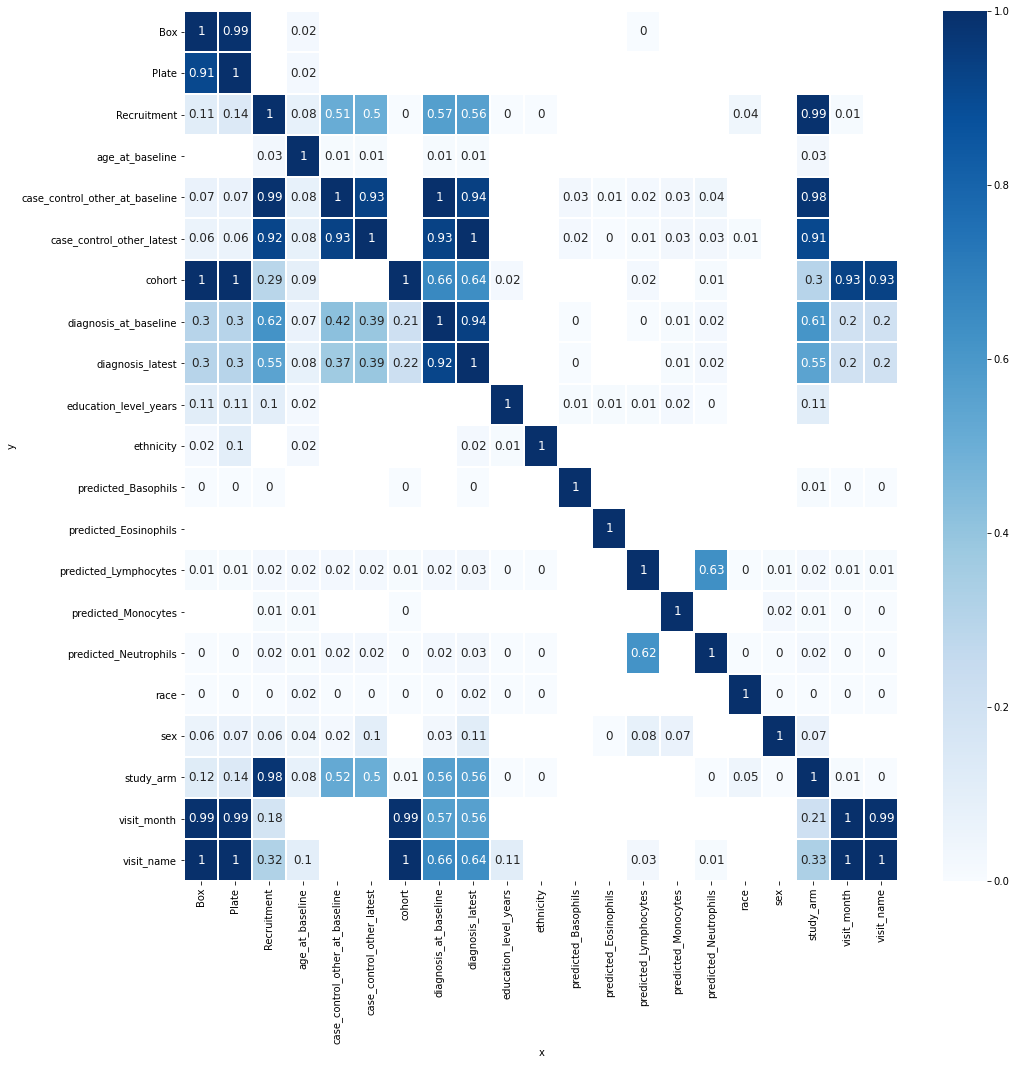

In [56]:
plt.figure(figsize=(16,16)) 
sns.heatmap(plot_matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.05, 
            annot=True, annot_kws={"fontsize":12})
plt.show()

In [57]:
temp_df = info_df[list(set(cfrac_covs) | set(cfracs_df.columns))]
cats_df = temp_df.select_dtypes(include=['object'])
print(cats_df.shape)
dums_df = pd.get_dummies(cats_df)
print(dums_df.shape)

covs_df = temp_df.merge(dums_df, how='inner', left_index=True, right_index=True)
print(covs_df.shape)

(8356, 14)
(8356, 267)
(8356, 288)


(274, 274)


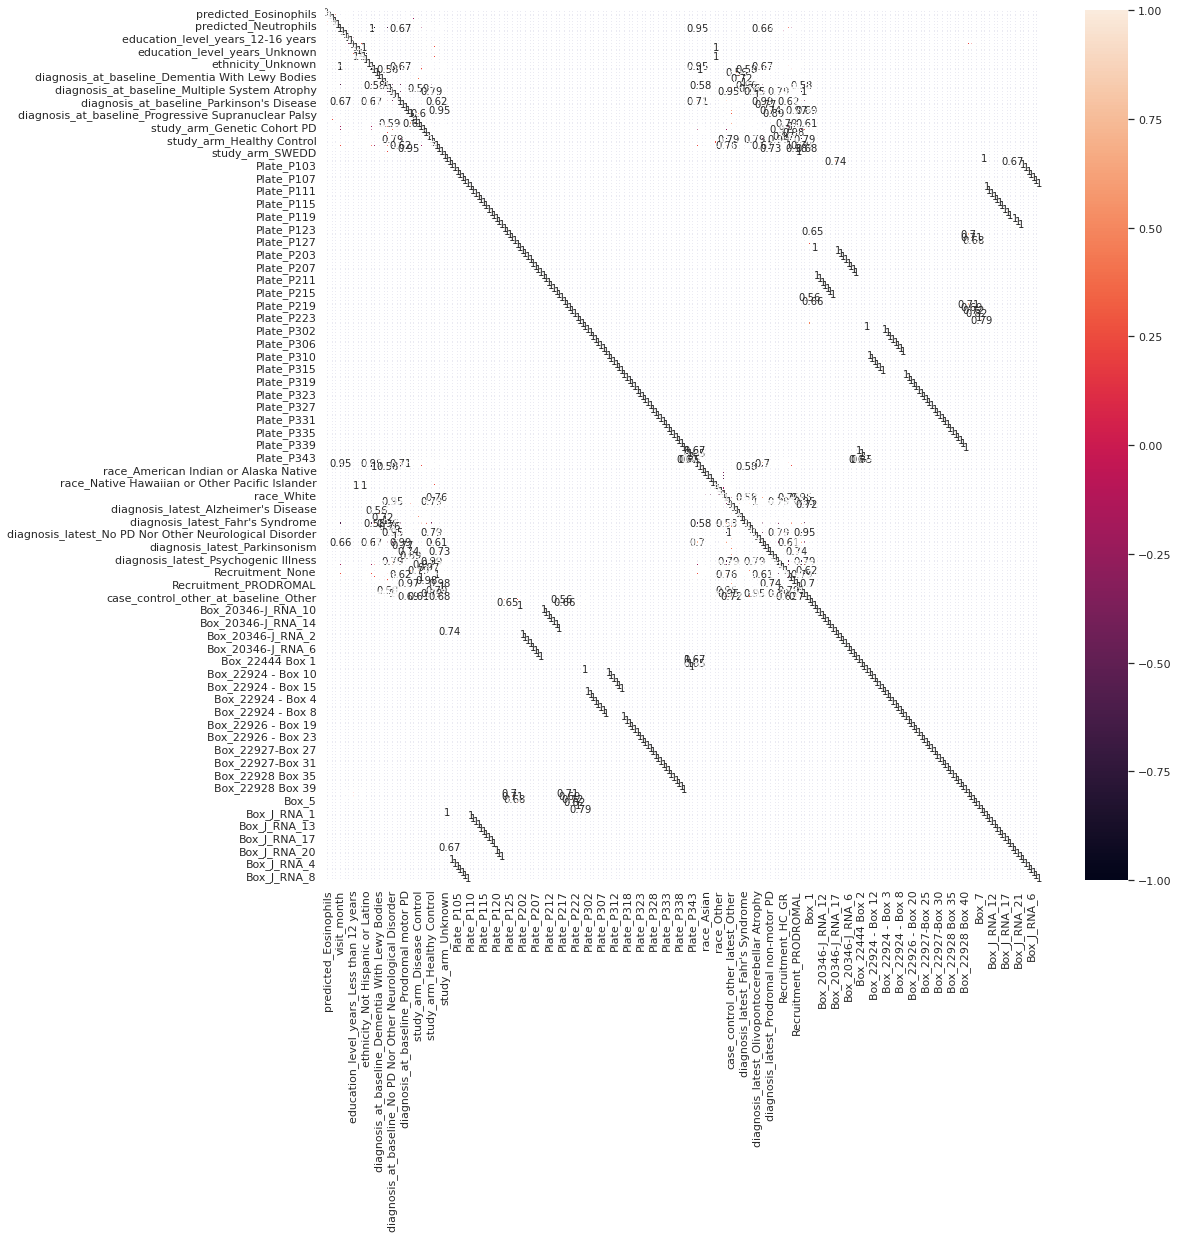

In [58]:
sns.set()
cor = covs_df.corr(method='pearson')
cor.dropna(how='all', inplace=True)
print(cor.shape)
plt.figure(figsize=(16,16))        
sns.heatmap(cor[(cor > 0.22) | (cor < -0.22)], annot=True, annot_kws={"fontsize":10}, \
            linewidths=0.05)    
plt.show()

In [59]:
# a lot of warning can be generated related to number of members and n_splits=4
# so temp supress warnings
warnings.filterwarnings('ignore')

matrix_df = pps.matrix(info_df)
matrix_df = matrix_df.loc[matrix_df['ppscore'] > 0]
print(matrix_df.shape)

default_max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 100)
display(matrix_df)
pd.set_option('display.max_rows', default_max_rows)

# restore defaults warning setting
# warnings.filterwarnings('default')
warnings.filterwarnings('once')

(575, 9)


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,cohort,cohort,1.000000e+00,predict_itself,True,None,0.000000,1.000000,None
5,cohort,visit_name,9.995974e-01,classification,True,weighted F1,0.503200,0.999800,DecisionTreeClassifier()
6,cohort,visit_month,9.921591e-01,regression,True,mean absolute error,0.457400,0.003586,DecisionTreeRegressor()
10,cohort,race,2.974377e-07,classification,True,weighted F1,0.886625,0.886625,DecisionTreeClassifier()
12,cohort,diagnosis_at_baseline,2.148418e-01,classification,True,weighted F1,0.300000,0.450389,DecisionTreeClassifier()
...,...,...,...,...,...,...,...,...,...
1346,predicted_Neutrophils,case_control_other_at_baseline,3.629832e-02,classification,True,weighted F1,0.474800,0.493864,DecisionTreeClassifier()
1347,predicted_Neutrophils,case_control_other_latest,3.388815e-02,classification,True,weighted F1,0.463000,0.481198,DecisionTreeClassifier()
1348,predicted_Neutrophils,study_arm,3.677032e-03,classification,True,weighted F1,0.319428,0.321931,DecisionTreeClassifier()
1366,predicted_Neutrophils,predicted_Lymphocytes,6.255009e-01,regression,True,mean absolute error,5.455953,2.043249,DecisionTreeRegressor()


In [60]:
matrix_df['ppscore'] = matrix_df['ppscore'].round(2)
plot_matrix_df = matrix_df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
print(plot_matrix_df.shape)
display(plot_matrix_df)

(37, 37)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


x,Box,Concentration,Input_RNASeq__ng_,Input_miRNA__ng_,Normalization_Volume__30ng_ul_,Plate,Position,RIN_Value,Recruitment,Specimen_Quantity,...,predicted_Monocytes,predicted_Neutrophils,prodromal_category,race,sex,study_arm,visit,visit_month,visit_name,wgsid
y,,,,,,,,,,,,,,,,,,,,,
Box,1.00,NaN,0.00,0.00,0.00,0.99,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.62
Concentration,NaN,1.00,0.05,0.05,0.82,NaN,NaN,NaN,NaN,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Input_RNASeq__ng_,0.04,0.03,1.00,0.99,NaN,0.10,NaN,NaN,NaN,0.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Input_miRNA__ng_,0.04,0.03,0.99,1.00,NaN,0.10,NaN,NaN,NaN,0.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Normalization_Volume__30ng_ul_,NaN,0.85,0.18,0.18,1.00,NaN,NaN,NaN,NaN,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Plate,0.91,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.64
Position,NaN,NaN,0.00,0.00,NaN,0.00,1.00,0.00,0.01,0.01,...,NaN,NaN,0.00,NaN,NaN,0.01,0.01,NaN,NaN,0.18
RIN_Value,0.01,NaN,NaN,NaN,NaN,0.01,NaN,1.00,0.01,NaN,...,NaN,NaN,NaN,NaN,NaN,0.01,NaN,0.01,0.01,NaN
Recruitment,0.11,NaN,0.02,0.02,0.00,0.14,0.05,0.02,1.00,0.00,...,NaN,NaN,0.06,0.04,NaN,0.99,0.00,0.01,NaN,0.68


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


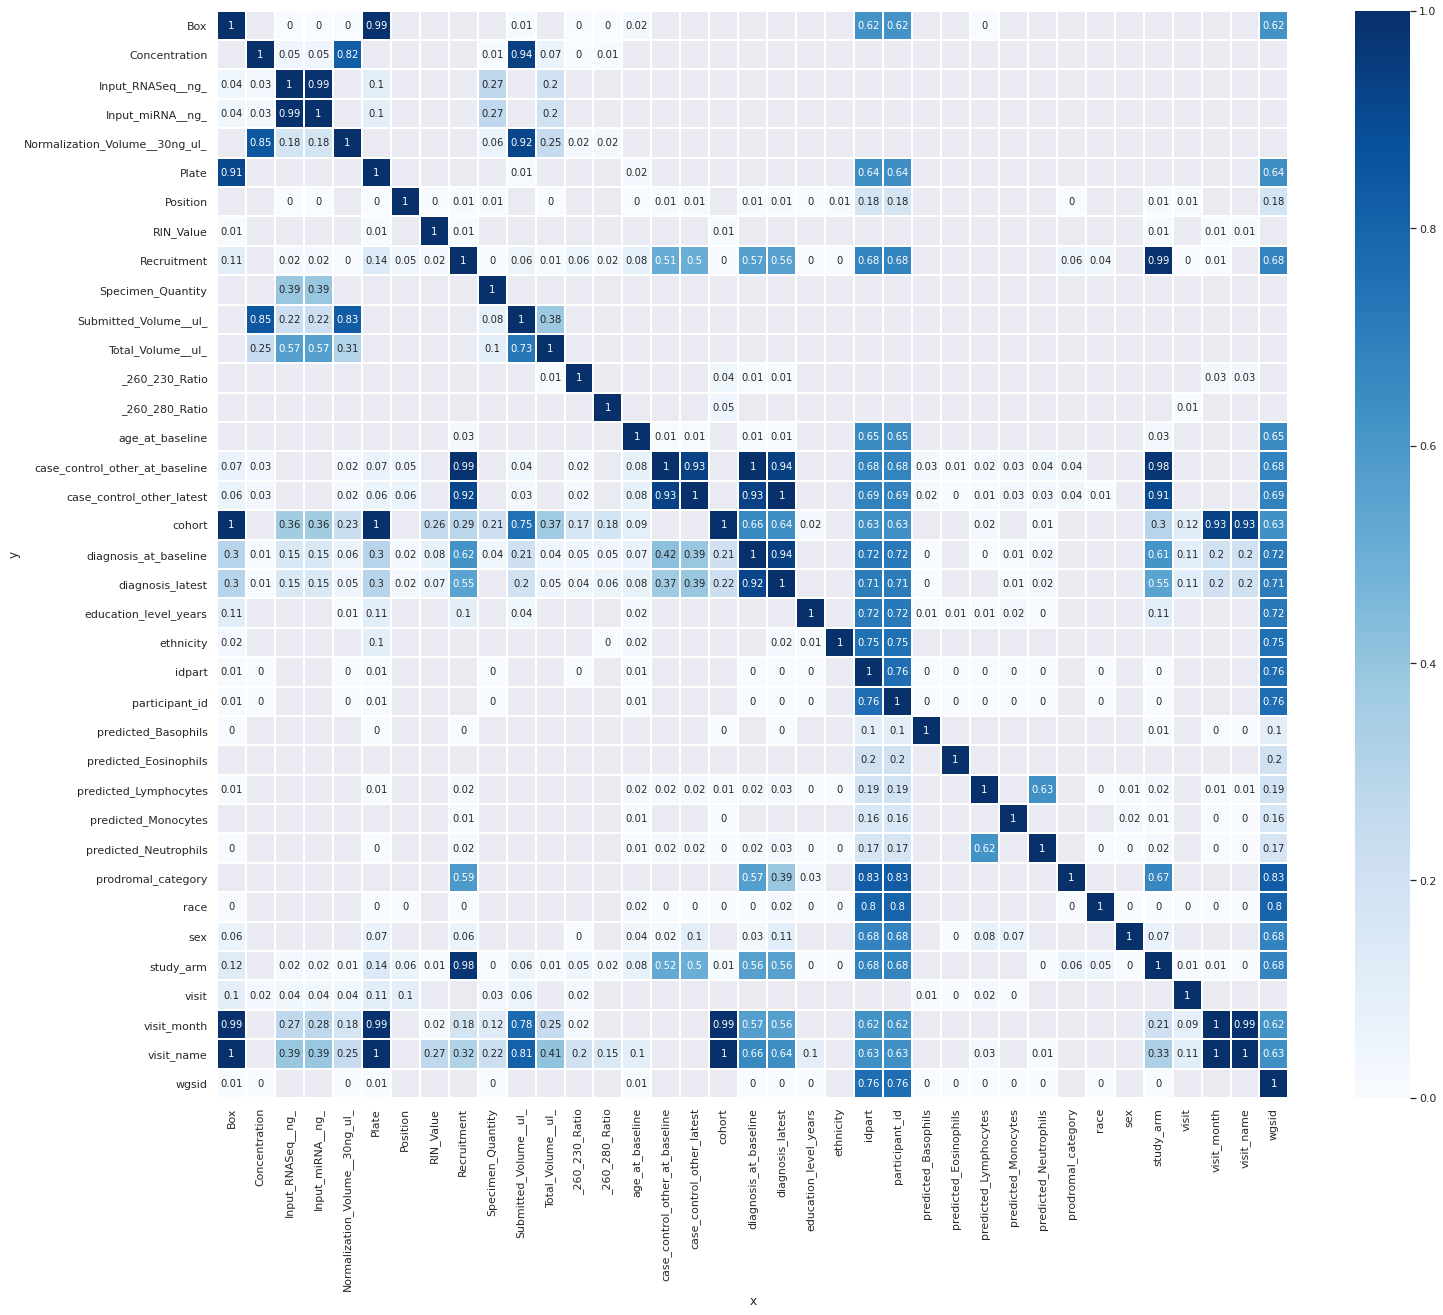

In [61]:
plt.figure(figsize=(24,20)) 
sns.heatmap(plot_matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.05, 
            annot=True, annot_kws={"fontsize":10})
plt.show()

In [62]:
info_df.select_dtypes(include=['object']).columns

Index(['cohort', 'idpart', 'visit', 'wgsid', 'participant_id', 'visit_name',
       'sex', 'ethnicity', 'race', 'education_level_years',
       'diagnosis_at_baseline', 'diagnosis_latest',
       'case_control_other_at_baseline', 'case_control_other_latest',
       'study_arm', 'prodromal_category', 'Recruitment', 'Box', 'Plate'],
      dtype='object')

In [64]:
# cats_df = info_df.select_dtypes(include=['object'])
cats_df = info_df[['cohort', 'visit', 'visit_name',
                   'sex', 'ethnicity', 'race', 'education_level_years',
                   'diagnosis_at_baseline', 'diagnosis_latest',
                   'case_control_other_at_baseline', 'case_control_other_latest',
                   'study_arm', 'prodromal_category', 'Recruitment', 'Box', 'Plate']]
print(cats_df.shape)
dums_df = pd.get_dummies(cats_df)
print(dums_df.shape)

covs_df = info_df.merge(dums_df, how='inner', left_index=True, right_index=True)
print(covs_df.shape)

(8356, 16)
(8356, 278)
(8356, 315)


(296, 296)


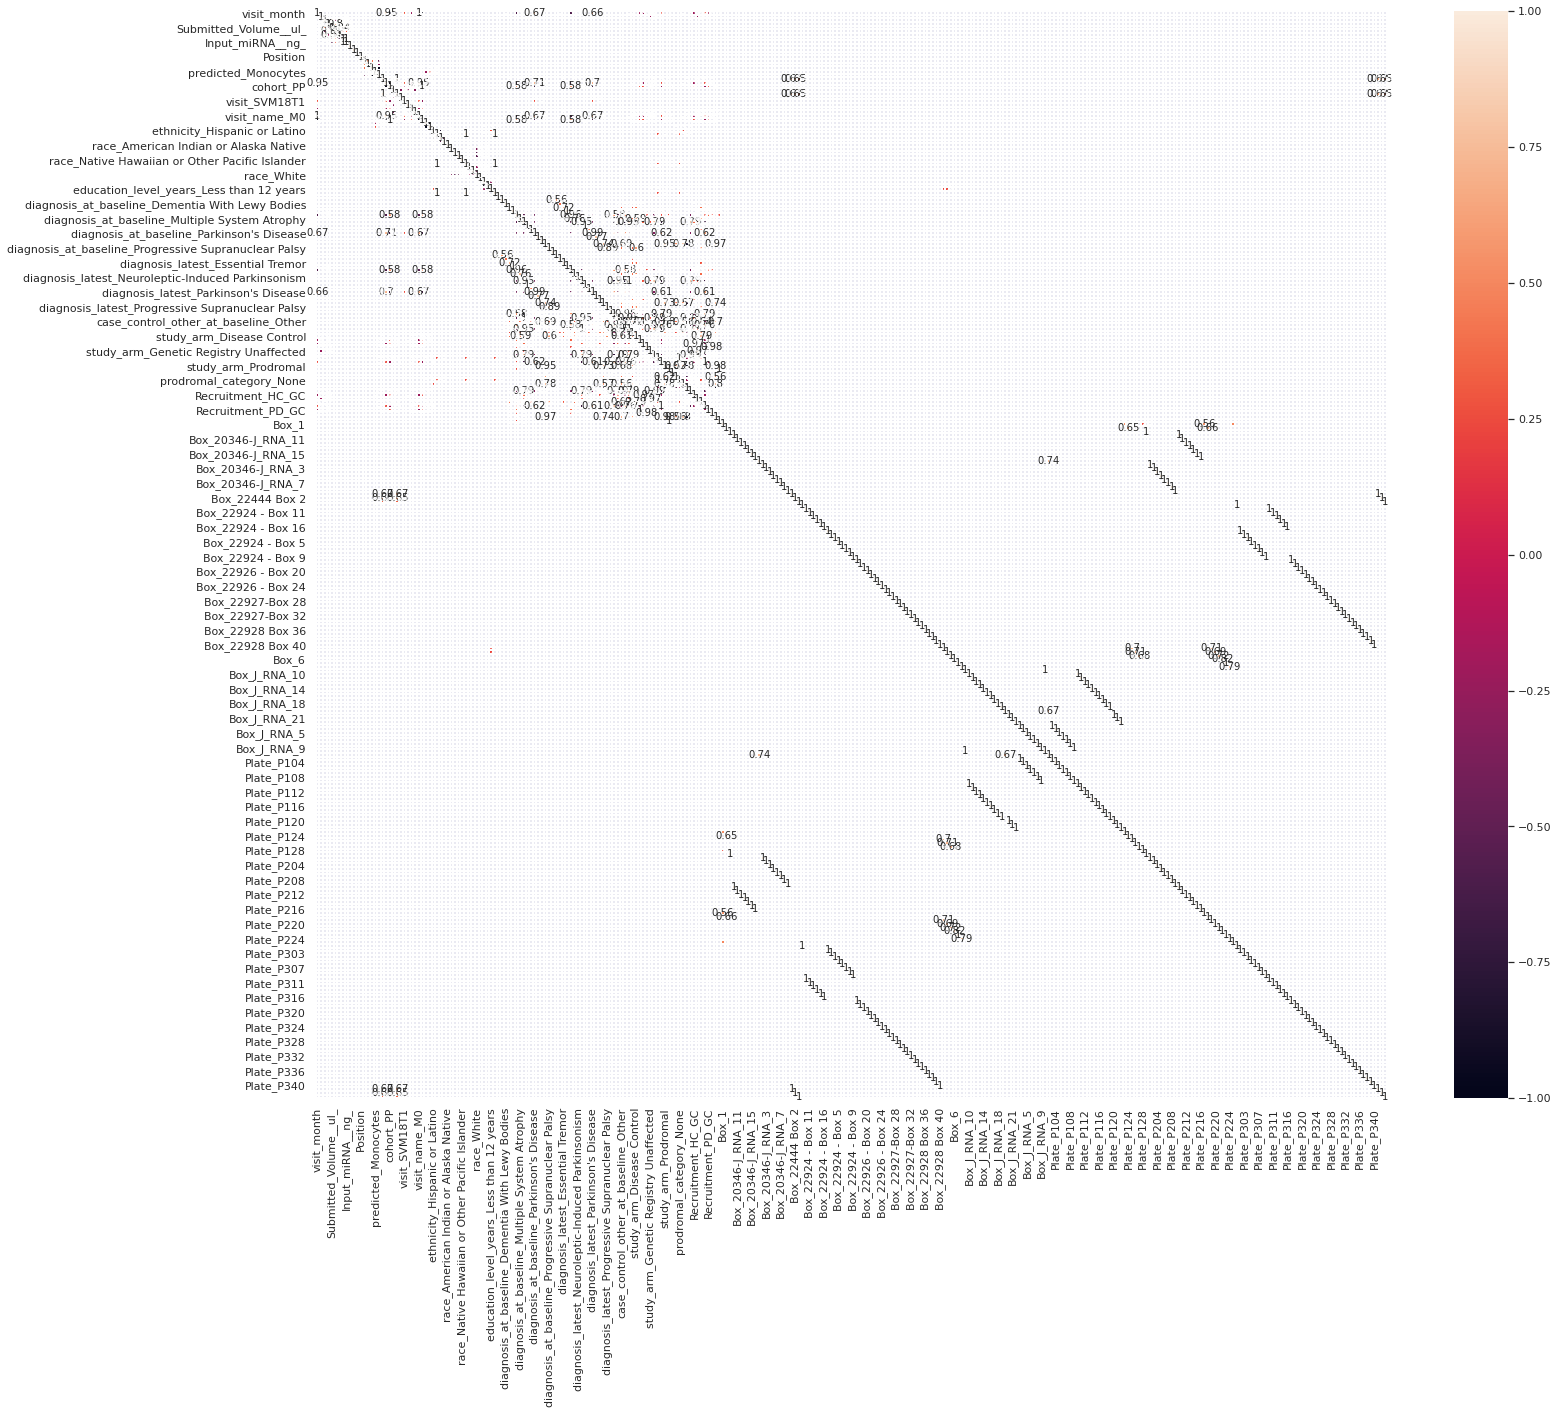

In [65]:
sns.set()
cor = covs_df.corr(method='pearson')
cor.dropna(how='all', inplace=True)
print(cor.shape)
plt.figure(figsize=(24,20))        
sns.heatmap(cor[(cor > 0.22) | (cor < -0.22)], annot=True, annot_kws={"fontsize":10}, \
            linewidths=0.05)
# sns.heatmap(cor[(cor > 0.1) | (cor < -0.1)], annot=True, annot_kws={"fontsize":12}, \
#             linewidths=0.05)
plt.show()